# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
# from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import seaborn a

from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['/home/rgadea/anaconda3/envs/tensorflow3/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/lib-dynload', '', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython']


In [2]:
from tensorflow.keras import backend as K
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
print(tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# physical_devices = tf.config.experimental.list_physical_devices('XLA_GPU')
# print(physical_devices)

# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))
# tf.config.experimental.set_visible_devices([], 'XLA_GPU')

# gpus = tf.config.experimental.list_physical_devices('XLA_GPU')
# tf.config.experimental.set_memory_growth(gpus[0], True)

# tf.config.experimental.get_visible_devices()
print(tf.test.is_gpu_available())

1.13.1
True


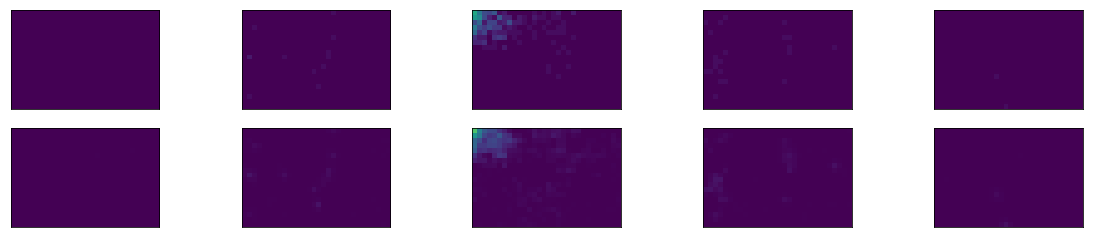

3593


In [19]:
n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    idea=np.random.randint(1,x_test.shape[0])
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idea].reshape(img_colsA,img_rows ).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idea].reshape(img_colsA, img_rows).transpose(),vmin=0, vmax=30)
    plt.viridis()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(idea)
# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


## Vamos introducir los datos de petalo preprocesados en pyhton


In [3]:
import scipy.io as sio
import hdf5storage
# datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total_2_distancias_red.mat')
# conjunto_datos= datos_matlab.get('photodefbox2_todo_fil5')
npzfile = np.load('../conjuntos_datos_reconstruidos/fil5_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
npzfile.files

conjunto_datos= npzfile['arr_0']
conjunto_datos=conjunto_datos[:,:]
# npzfile = np.load('../conjuntos_datos_reconstruidos/fil2_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
# npzfile.files

# conjunto_datos2= npzfile['arr_0']

# conjunto_datos=np.concatenate((conjunto_datos1,conjunto_datos2), axis=0)
# print(conjunto_datos.shape)
# conjunto_datos=conjunto_datos1
print(conjunto_datos.shape)
# print(conjunto_datos[:10,6:26])

(50000, 3518)


## Network parameters:

In [4]:
batch_size = 250
nb_classes = 10
nb_epoch = 1000


# input image dimensions
img_rows, img_cols = 20, 33
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (4, 4)

## Prepare data into training and test set.

In [6]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
# conjunto_datos=photodefbox2_todo_e
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)
maxInColumns = np.amax(conjunto_datos, axis=0)
print (maxInColumns[1])
# n, bins, patches = plt.hist(conjunto_datos[:,1], 400, normed=0, facecolor='green', alpha=0.75)


idea=conjunto_datos[:,6:3506]
veamos=idea.reshape(idea.shape[0],175, 20)
veamos2=np.zeros([idea.shape[0],20,175])
veamos2_3=np.zeros([idea.shape[0],20,525])
sector2=np.zeros([idea.shape[0],20,img_cols])
veamos3=np.zeros([idea.shape[0],175])
# for i in range(idea.shape[0]):
for i in range(idea.shape[0]):
    veamos2[i]=np.reshape(veamos[i].transpose(), [20,175])
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1) 
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    sector2[i]=veamos2_3[i,:,indice_inferior:indice_superior]
    

print('sector shape:', sector2.shape)
conjunto_datos_nuevo=sector2.reshape(sector2.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo:', conjunto_datos_nuevo.shape)

50000
conjunto_datos shape: (50000, 3518)
194.99950513267174
sector shape: (50000, 20, 33)
conjunto_datos_nuevo: (50000, 660)


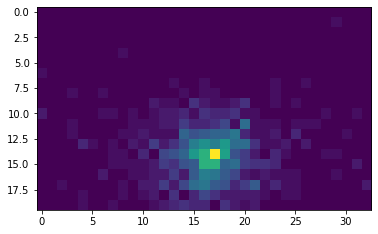

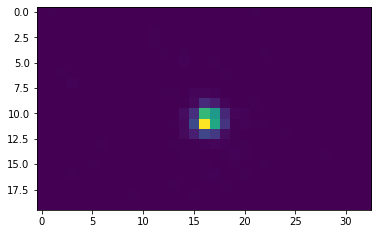

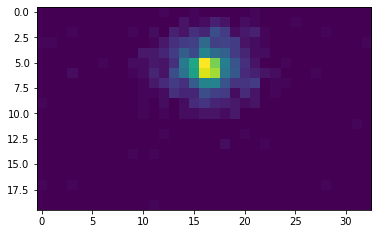

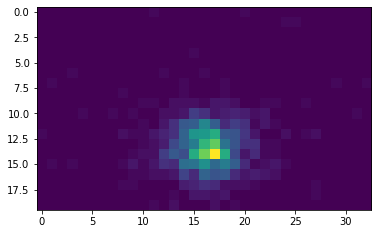

In [6]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,sector2.shape[0])
    plt.imshow(sector2[idea], cmap='viridis')
    plt.show()

In [7]:
tr_size=40
val_size=20
test_size=100-val_size-tr_size
conjunto_datos_nuevo2=np.concatenate((conjunto_datos[:,0:3],conjunto_datos_nuevo), axis=1)
tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


XY_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,:]


XY_test_bin0=XY_test[np.where((XY_test[:,1]>=164.9999) * (XY_test[:,1]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,1]>=171.000) * (XY_test[:,1]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,1]>=177.000) * (XY_test[:,1]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,1]>=183.000) * (XY_test[:,1]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,1]>=189.0000))]

X_train=conjunto_datos_nuevo2[:tamanyo_tr,3:]
X_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,3:]
X_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,3:]

X_test_bin0=XY_test_bin0[:,3:]
Y_test_bin0=XY_test_bin0[:,1]
print(X_test_bin0.shape)
X_test_bin1=XY_test_bin1[:,3:]
Y_test_bin1=XY_test_bin1[:,1]
print(X_test_bin1.shape)
X_test_bin2=XY_test_bin2[:,3:]
Y_test_bin2=XY_test_bin2[:,1]
print(X_test_bin2.shape)
X_test_bin3=XY_test_bin3[:,3:]
Y_test_bin3=XY_test_bin3[:,1]
print(X_test_bin3.shape)
X_test_bin4=XY_test_bin4[:,3:]
Y_test_bin4=XY_test_bin4[:,1]
print(X_test_bin4.shape)



Y_train=conjunto_datos_nuevo2[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

20000
10000
20000
(8655, 660)
(3929, 660)
(2550, 660)
(2132, 660)
(2734, 660)


In [8]:


X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols,1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols,1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

X_test_bin0 = X_test_bin0.reshape(X_test_bin0.shape[0], img_rows, img_cols,1)
X_test_bin1 = X_test_bin1.reshape(X_test_bin1.shape[0], img_rows, img_cols,1)
X_test_bin2 = X_test_bin2.reshape(X_test_bin2.shape[0], img_rows, img_cols,1)
X_test_bin3 = X_test_bin3.reshape(X_test_bin3.shape[0], img_rows, img_cols,1)
X_test_bin4 = X_test_bin4.reshape(X_test_bin4.shape[0], img_rows, img_cols,1)

input_shape = (img_rows, img_cols,1)
#input_shape=input_shape.astype('int32')

In [9]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (20000, 20, 33, 1)
20000 train samples
10000 validation samples
20000 test samples


Display 20 random training images using image

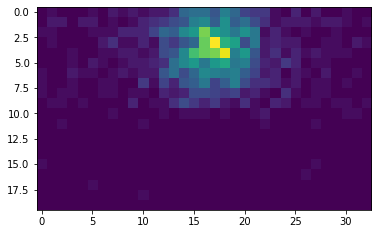

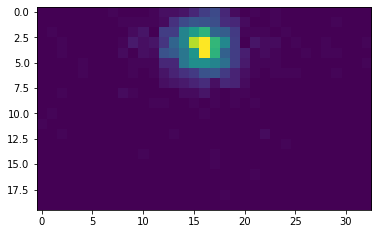

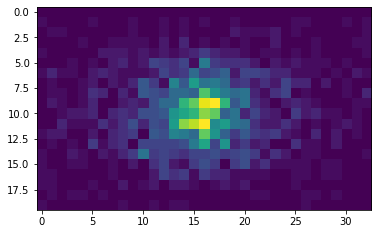

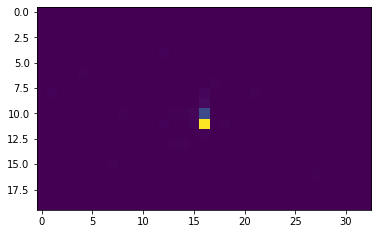

In [10]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea], [img_rows, img_cols]), cmap='viridis')
    plt.show()

## Build the CNN. 

In [11]:
model = Sequential()

model.add(Conv2D(8, kernel_size=kernel_size,
                        padding='same',
                        input_shape=(img_rows,img_cols,1)))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(16, kernel_size, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(32, kernel_size, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, kernel_size, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))

experimento="CNN_original_sector_{}x{}".format(img_rows,img_cols)
algoritmo='Nadam'

tensorboard=TensorBoard(log_dir="../logs/defs/{}{}{}".format(experimento,algoritmo,datetime.now()))

model.compile(loss='mean_squared_error',
              optimizer=algoritmo)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Show a summary of the model parameters. 

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 33, 8)         136       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 33, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 16, 16)        2064      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 16, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 8, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 8, 32)          8224      
__________

And now train the model and evaluate on the test set. 

In [13]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val),
          callbacks=[tensorboard])

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 10000 samples
Epoch 1/1000
20000/20000 [==============================] - 3s 140us/step - loss: 7664.8583 - val_loss: 2214.3885
Epoch 2/1000
20000/20000 [==============================] - 1s 43us/step - loss: 545.3173 - val_loss: 243.4978
Epoch 3/1000
20000/20000 [==============================] - 1s 42us/step - loss: 192.6645 - val_loss: 191.4670
Epoch 4/1000
20000/20000 [==============================] - 1s 44us/step - loss: 135.0332 - val_loss: 79.4560
Epoch 5/1000
20000/20000 [==============================] - 1s 45us/step - loss: 95.5466 - val_loss: 156.7627
Epoch 6/1000
20000/20000 [==============================] - 1s 45us/step - loss: 81.1121 - val_loss: 59.8984
Epoch 7/1000
20000/20000 [==============================] - 1s 45us/step - loss: 73.8680 - val_loss: 35.9223
Epoch 8/1000
20000/20000 [==============================] - 1s 47us/step - loss: 68.7213 - val_loss: 30.4997
Epoch 9/1000
20000/

In [14]:
dt = datetime.now().replace(second=0, microsecond=0)
model.save_weights('../redes_CNN_R/defs/CNN_regression_R_{}_{}_{}_{}_{}'.format(nb_epoch,batch_size,experimento,algoritmo,dt))

In [15]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test mse:', score)
# print('Test mae:', score[1])
Y_test_predicted=model.predict(X_test)
print(Y_test_predicted[:10].flatten())
print(Y_test[:10])
error_prediction=Y_test-Y_test_predicted.flatten()

print(error_prediction[:10])

Test mse: 0.7101139059305192
[166.23833 190.80432 175.94872 182.50053 166.9536  173.05704 165.61894
 191.87624 193.31165 169.01535]
[167.54290689 191.87006942 174.66517941 181.1626643  166.95069104
 173.91936793 165.80804673 194.89500483 193.64193061 168.46273077]
[ 1.30457987e+00  1.06574813e+00 -1.28353580e+00 -1.33786975e+00
 -2.90698483e-03  8.62330578e-01  1.89104464e-01  3.01876887e+00
  3.30285099e-01 -5.52619576e-01]


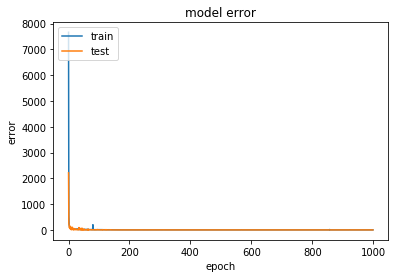

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
#print(error_prediction)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


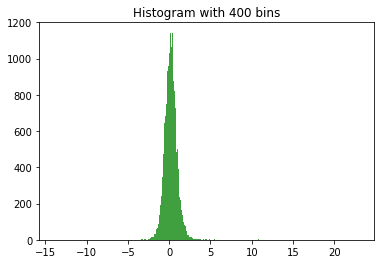

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 400
    # variables        = 3
    chi-square         = 49262.8569
    reduced chi-square = 124.087801
    Akaike info crit   = 1931.38445
    Bayesian info crit = 1943.35884
[[Variables]]
    amp:  1092.89108 +/- 3.84865459 (0.35%) (init = 1000)
    cen:  0.12342920 +/- 0.00265872 (2.15%) (init = 0)
    wid:  0.92465851 +/- 0.00376000 (0.41%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



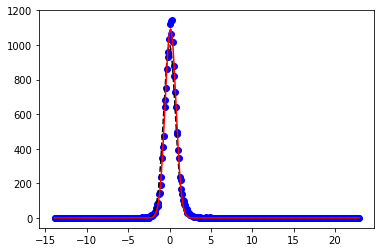

In [18]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [19]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [20]:
print(FWHM)

1.5396574152023121


[[166.23833]
 [166.9536 ]
 [165.61894]
 ...
 [165.97534]
 [165.60509]
 [165.75839]]


/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


1.729812080819771


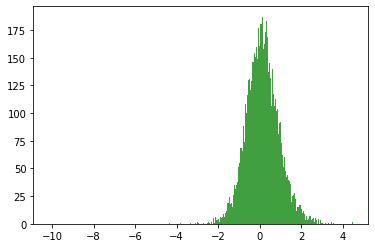

In [21]:
Y_test_bin0_predicted=model.predict(X_test_bin0)
print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


1.485724698692836


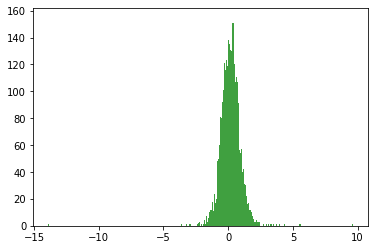

In [22]:
Y_test_bin1_predicted=model.predict(X_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


1.28642225786484


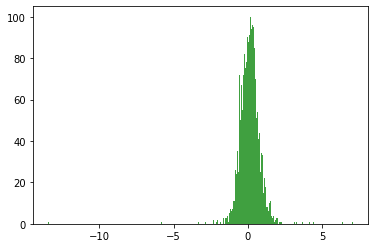

In [23]:
Y_test_bin2_predicted=model.predict(X_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


1.2406070291820308


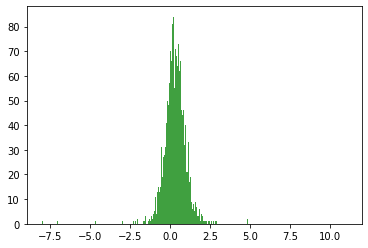

In [24]:
Y_test_bin3_predicted=model.predict(X_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


1.4875460403109768
1.2406070291820308
1.28642225786484
1.485724698692836
1.729812080819771


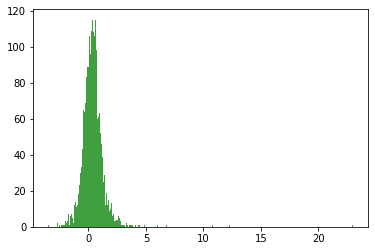

In [25]:
Y_test_bin4_predicted=model.predict(X_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)

In [26]:
# veamosd1 =photodefbox2_todo_fil1_e[:,-9]
# veamosd2 =[photodefbox2_todo_fil3_e(:,end-3);photodefbox2_todo_fil4_e(:,end-3)];
# veamosen1 =photodefbox2_todo_fil1_e[:,-11]
veamoser1=conjunto_datos[tamanyo_tr+tamanyo_val:numero_muestras,-1]
print(veamoser1.shape)
print(error_prediction.shape)
# veamosd1 =np.concatenate((photodefbox2_todo_fil1_e[:,-9],photodefbox2_todo_fil2_e[:,-9]),axis=0);
# # veerror_predictionsd2 =[photodefbox2_todo_fil3_e(:,end-3);photodefbox2_todo_fil4_e(:,end-3)];
# veamosen1 =np.concatenate((photodefbox2_todo_fil1_e[:,-11],photodefbox2_todo_fil2_e[:,-11]),axis=0);
# veamoser1=np.concatenate((photodefbox2_todo_fil1_e[:,-1],photodefbox2_todo_fil2_e[:,-1]),axis=0);

(20000,)
(20000,)


Veamos ahora los histogramnas 2d que nos interesan

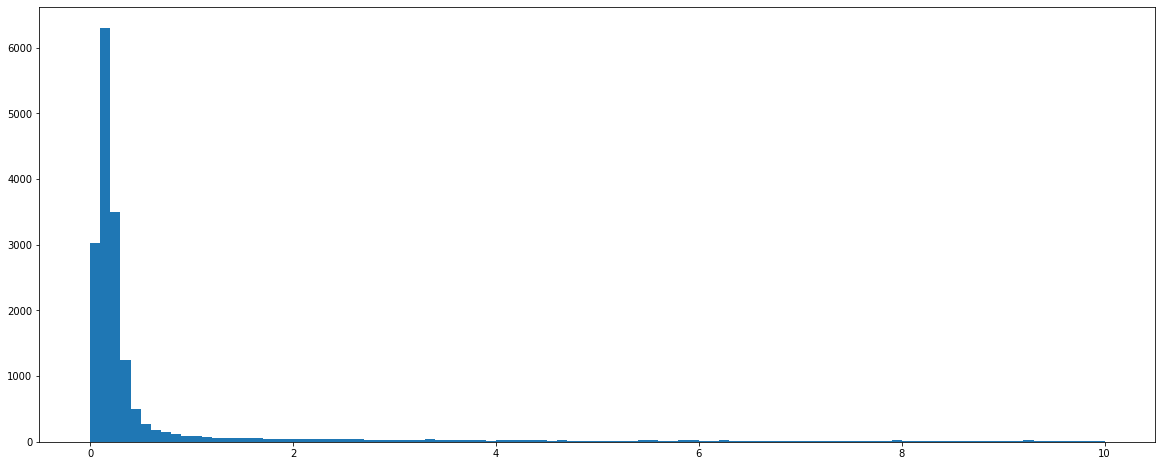

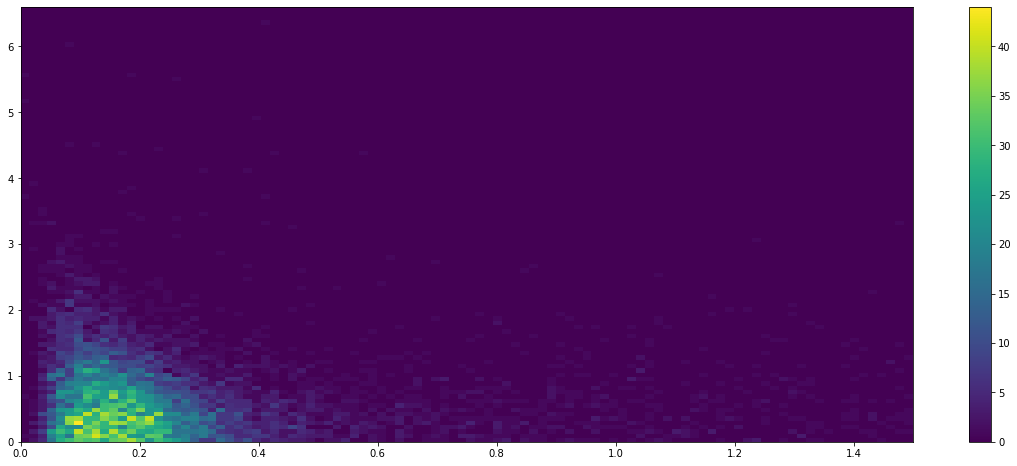

In [27]:

plt.figure(figsize=(20, 8))
plt.hist(veamoser1, bins=100, range=(0,10))

plt.figure(figsize=(20, 8))
h1=plt.hist2d(veamoser1, error_prediction, bins=100,range=[(0,1.5),(0,6.6)])
plt.colorbar(h1[3])
plt.show()

# plt.show()
# plt.figure(figsize=(20, 8))
# h2=plt.hist2d(veamoser1,veamosd1, bins=50, range=[(0,0.6),(0,0.6)])
# plt.colorbar(h2[3])
# plt.show()

# plt.figure(figsize=(20, 8))
# h3=plt.hist2d(veamoser1,veamosen1, bins=100, range=[(0,0.5),(0,0.5)])
# plt.colorbar(h3[3])
# plt.show()